In [1]:
import numpy as np
import sympy as sym

In [2]:
#assume identical motor and joint pulleys
R_p, R_m = sym.symbols(r'R_p, R_m')
subslist = [(R_m, 9 ), (R_p, 9)]

## Structure matrix and transmission jacobian

#### Definitions:
Let...
- $\mathbf{A}$ be the structure matrix
- $f$ be the vector of tension forces in the tendons, 
- $\theta$ be the joint angle vector,
- $\tau$ be the joint torque vector, 
- $v$ be the tendon linear velocity vector, 
- $\phi$ be the motor angle vector


By definition:
$\mathbf{\tau} = \mathbf{Af}$

Now apply conservation of power:

$
\dot{\theta}^T\tau = v^Tf
$

$
\dot{\theta}^T\mathbf{Af} = v^Tf
$

$
\dot{\theta}^T\mathbf{A} = v^T
$

Note the relation between the linear speeds of the tendons and motor angular velocity:
$
v=R\dot{\phi}
$

To get the joint angle mapping, we can integrate but the constant of integration means the joint and motor
angles are relative to a reference point which we can get by using the hardstop.

$
\theta^T\mathbf{A} = \mathbf{R}\phi
$

$
\mathbf{A}^T\theta = \mathbf{R}\phi
$

$
\theta = {\mathbf{A}^T}^\dag \mathbf{R} \phi
$

Therefore, the transmission jacobian is computed: $\mathbf{T} =  {\mathbf{A}^T}^\dag \mathbf{R} $

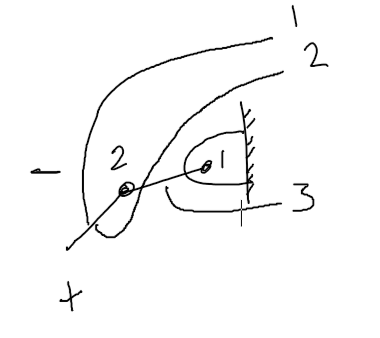

Assuming identical pulleys on the routing diagram, we have the structure matrix A:

$\mathbf{A}=
\begin{bmatrix}
-R & -R & R \\
-R & R & 0 \\
\end{bmatrix}
$

The pseudoinverse of $\mathbf{A}^T$ is used to compute the transmission jacobian:

$
{\mathbf{A}^T}^\dag =
\begin{bmatrix}
-\frac{1}{3R} & -\frac{1}{3R} & \frac{1}{3R} \\
-\frac{1}{2R} & \frac{1}{2R} & 0 \\
\end{bmatrix}
$

**Note that the pinv() function in sympy doesn't give us the $A^\dag$ that we want

In [3]:
#structure matrix
A = sym.Matrix([[-R_p, -R_p, R_p],
                [-R_p, R_p, 0]])

Atpinv = sym.Matrix([[-1/(3*R_p), -1/(3*R_p), 1/(3*R_p)],
                [-1/(2*R_p), 1/(2*R_p), 0]])

Apinv = Atpinv.T

# A = sym.Matrix([[R_p, R_p, -R_p],
#                 [0, R_p, -R_p]])

R = sym.eye(3) * R_m #motor shaft matrix

#transmission jacobian
T = Atpinv * R

In [4]:
#confirm the structure matrix and the inverse is correct
display(A)
display(Atpinv)
#display(Atpinv * A.T)

Matrix([
[-R_p, -R_p, R_p],
[-R_p,  R_p,   0]])

Matrix([
[-1/(3*R_p), -1/(3*R_p), 1/(3*R_p)],
[-1/(2*R_p),  1/(2*R_p),         0]])

In [5]:
T.subs(subslist) #radii in mm

Matrix([
[-1/3, -1/3, 1/3],
[-1/2,  1/2,   0]])

## Forward and inverse control

Forward problem: given motor angle vector relative to the reference, we can compute the joint angles using the transmission matrix as mentioned above.

Inverse problem: given a desired joint configuration, we can drive the finger to the configuration by using a controller that maps the joint error to $\tau$ which we use to
do torque control until we reach position

Torques on the joints due to gravity, assuming the centroid of the link is located at $x_c$ from the corresponding
joint:

$
\tau_1 = m_1 x_{c,1} cos(\theta_1) + m_2(x_{c,1} cos(\theta_1) + x_{c,2}cos(\theta_1 + \theta_2))
$

$
\tau_2 =  m_2 x_{c,2} cos(\theta_1+\theta_2)
$


We can use the equation $\tau = Af$ to get the relation between motor and joint torques. This tells us the motor torques to exert in order to get the torques on the joints. We should also add the torque due to gravity, if applicable.

$
\tau_m = R^{-1} A^\dag \tau_j
$

Note that the antagonistic configuration of the tendons means that increasing motor torque does not necessarily mean that we increase joint torque. Consider the situation where we increase the tension in tendons 1 and 2 simultaneously, these will cancel out and provide no torque. This should not be an issue using the above equation as the solution will be unique. However, this example illustrates that going the other way, $\tau_m \rightarrow \tau_j$, cannot be done uniquely.


First, let the error be computed based off the joint positions estimated from the motor positions $\phi$. 

$
e = (\theta_d - \theta(\phi))
$ 

Then, design a controller using this error for joint torque control:

$
\tau_j = PID(e)
$

Finally, we get the motor torques:

$
\tau_m = R^{-1} A^\dag \tau_j
$

Note that we can hardcode the matrices, including the pseudoinverses, for speed since they are not dependent on joint configurations.

In [6]:
R.inv() * Apinv

Matrix([
[-1/(3*R_m*R_p), -1/(2*R_m*R_p)],
[-1/(3*R_m*R_p),  1/(2*R_m*R_p)],
[ 1/(3*R_m*R_p),              0]])

## dynamics-based model of the finger

polar moment of interia / angular inertia from CAD, neglect friction